# Import Library

In [2]:
import pandas as pd
import numpy as np
import re
import string
import csv 
import requests
from io import StringIO
import os
import shutil
import joblib
import warnings
warnings.filterwarnings('ignore')

seed = 0
np.random.seed(seed)
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import tf_keras
from transformers import BertTokenizer, TFBertForSequenceClassification

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2026-01-18 09:49:14.494935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768729754.659149      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768729754.705446      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768729755.068174      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:17

# Load Dataset

In [3]:
raw_df = pd.read_csv("/kaggle/input/traveloka-raw-reviews/traveloka_raw_reviews.csv")
raw_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,e4d29161-2f75-4cfd-bc75-e46a57cc57f9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mantab,5,0,5.36.0,2026-01-16 13:19:24,Hello! Thank you very much for the positive re...,2026-01-16 13:35:07,5.36.0
1,5e0113d8-8cbe-4f4e-8ebb-04037af63fb7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat membantu,5,0,NaN,2026-01-16 12:48:23,"Halo Kak, terima kasih banyak atas ratingnya. ...",2026-01-16 13:05:06,NaN
2,e303fec0-2d37-4cf5-bbe8-469c4671589e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,excellent,5,0,5.36.0,2026-01-16 12:32:08,Hello! Thank you very much for the positive re...,2026-01-16 12:35:05,5.36.0
3,13a6c59d-9e5a-483d-af2c-4cbadf6fca25,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,upps,5,0,5.35.0,2026-01-16 12:24:36,Hey there! We are so grateful for your support...,2026-01-16 12:35:07,5.35.0
4,63d11de3-9a4c-4a87-b91e-56cd27cf58e4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,memuaskan mantap,5,0,5.36.0,2026-01-16 12:24:25,"Hai Kak, terima kasih atas feedbacknya. Jika K...",2026-01-16 12:35:09,5.36.0


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198886 entries, 0 to 198885
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              198886 non-null  object
 1   userName              198886 non-null  object
 2   userImage             198886 non-null  object
 3   content               198833 non-null  object
 4   score                 198886 non-null  int64 
 5   thumbsUpCount         198886 non-null  int64 
 6   reviewCreatedVersion  143567 non-null  object
 7   at                    198886 non-null  object
 8   replyContent          87217 non-null   object
 9   repliedAt             87234 non-null   object
 10  appVersion            143567 non-null  object
dtypes: int64(2), object(9)
memory usage: 16.7+ MB


# EDA

In [5]:
# Check Missing Values
raw_df.isna().sum()

reviewId                     0
userName                     0
userImage                    0
content                     53
score                        0
thumbsUpCount                0
reviewCreatedVersion     55319
at                           0
replyContent            111669
repliedAt               111652
appVersion               55319
dtype: int64

In [6]:
# Drop Unused with lots of NA
new_df = raw_df.drop(['reviewCreatedVersion', 'replyContent', 'repliedAt', 'appVersion'], axis=1)

# Drop Missing Values
new_df = new_df.dropna()

# Drop duplicate
new_df = new_df.drop_duplicates()

In [7]:
def cleaning_text(text):
  text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
  text = re.sub(r'#[A-Za-z0-9]+', ' ', text)
  text = re.sub(r'RT[\s]', ' ', text)
  text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
  text = re.sub(r'\d+', ' ', text)
  text = re.sub(r'[^\w\s]', ' ', text)

  text = text.replace('\n', ' ')
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.strip(' ')
  return text

def casefolding_text(text):
  text = text.lower()
  return text

slang_dict = {
    "yg": "yang", "gk": "tidak", "ga": "tidak", "gak": "tidak", "engga": "tidak",
    "bgt": "banget", "sdh": "sudah", "udh": "sudah", "blm": "belum",
    "dgn": "dengan", "tdk": "tidak", "jgn": "jangan", "sy": "saya",
    "aku": "saya", "gw": "saya", "gue": "saya", "lu": "kamu", "loe": "kamu",
    "kalo": "kalau", "klo": "kalau", "tp": "tapi", "krn": "karena",
    "bgs": "bagus", "thx": "terima kasih", "tq": "terima kasih", "makasih": "terima kasih",
    "bad": "buruk", "good": "bagus", "best": "terbaik", "ancur": "hancur", "parah": "buruk"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slang_dict:
            fixed_words.append(slang_dict[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

def tokenizing_text(text):
  text = word_tokenize(text)
  return text

stop_words = {'dan', 'yang', 'di', 'ke', 'dari', 'ini', 'itu', 'untuk', 'pada', 'adalah', 'dengan', 'saya', 'kamu'}
keep_words = ["tidak", "bukan", "belum", "jangan", "masih", "tanpa", "banget", "sangat", "sekali"]
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(stop_words)
    listStopwords = listStopwords - set(keep_words)

    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [8]:
new_df['text_clean'] = new_df['content'].apply(cleaning_text)
new_df['text_casefoldingText'] = new_df['text_clean'].apply(casefolding_text)
new_df['text_slangwords'] = new_df['text_casefoldingText'].apply(fix_slangwords)
new_df['text_tokenizingText'] = new_df['text_slangwords'].apply(tokenizing_text)
new_df['text_stopword'] = new_df['text_tokenizingText'].apply(filteringText)
new_df['text_final'] = new_df['text_stopword'].apply(toSentence)

In [9]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198833 entries, 0 to 198885
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              198833 non-null  object
 1   userName              198833 non-null  object
 2   userImage             198833 non-null  object
 3   content               198833 non-null  object
 4   score                 198833 non-null  int64 
 5   thumbsUpCount         198833 non-null  int64 
 6   at                    198833 non-null  object
 7   text_clean            198833 non-null  object
 8   text_casefoldingText  198833 non-null  object
 9   text_slangwords       198833 non-null  object
 10  text_tokenizingText   198833 non-null  object
 11  text_stopword         198833 non-null  object
 12  text_final            198833 non-null  object
dtypes: int64(2), object(11)
memory usage: 21.2+ MB


# Visualization

In [10]:
def plot_wordcloud(text_series, title):
  all_text = ' '.join([' '.join(text) if isinstance(text, list) else str(text) for text in text_series])

  wordcloud = WordCloud(width=800, height=400,
                        background_color='white',
                        min_font_size=10).generate(all_text)

  plt.figure(figsize=(8, 8), facecolor=None)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(title)
  plt.tight_layout()
  plt.show()


def plot_freq_words(text, title, n_top=10, color_palette='viridis'):
  if isinstance(text.iloc[0], list):
    all_words = text.explode()
  else:
    all_words = text.astype(str).str.split().explode()

  count_df = all_words.value_counts().reset_index()
  count_df.columns = ['word', 'count']

  count_df = count_df[count_df['word'] != '']

  plt.figure(figsize=(10, 6))
  sns.barplot(
      x='count', 
      y='word', 
      hue='count',
      data=count_df.head(n_top), 
      palette=color_palette,
      legend=False
  )
  
  plt.title(title, fontsize=15, fontweight='bold')
  plt.xlabel('Frequency', fontsize=12)
  plt.ylabel('Words', fontsize=12)
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  plt.show()

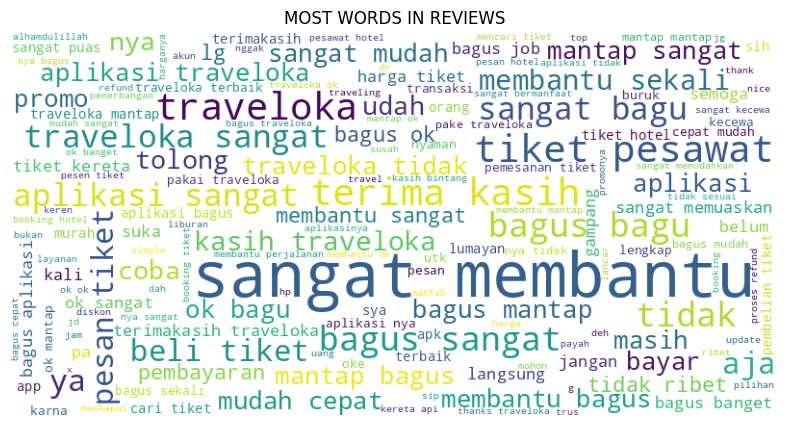

In [11]:
# The most frequently used words in Reviews
plot_wordcloud(new_df['text_stopword'],
               "MOST WORDS IN REVIEWS")

# Labeling

In [12]:
# Positive
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
  reader = csv.reader(StringIO(response.text), delimiter=',')
  for row in reader:
    lexicon_positive[row[0]] = int(row[1])
  print(f"Total positive words: {len(lexicon_positive)}")
else:
  print("Failed to fetch positive lexicon data")  


# Negative
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
  reader = csv.reader(StringIO(response.text), delimiter=',')
  for row in reader:
    lexicon_negative[row[0]] = int(row[1])
  print(f"Total negative words: {len(lexicon_positive)}")
else:
  print("Failed to fetch negative lexicon data")  

Total positive words: 3609
Total negative words: 3609


In [13]:
intersect_words = set(lexicon_positive.keys()) & set(lexicon_negative.keys())

print(f"Ada {len(intersect_words)} kata yang overlap")


for word in intersect_words:
    del lexicon_negative[word]

Ada 1142 kata yang overlap


In [14]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        pos_score = lexicon_positive.get(word, 0)
        neg_score = lexicon_negative.get(word, 0)
    
        if abs(pos_score) > abs(neg_score):
            score += pos_score
        else:
            score += neg_score
    
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'netral'
    
    return score, polarity

In [15]:
results = new_df['text_final'].apply(
    lambda x: sentiment_analysis_lexicon_indonesia(str(x).split()))

new_df['polarity_score'], new_df['polarity'] = zip(*results)
print(new_df['polarity'].value_counts())

polarity
positive    136396
netral       36012
negative     26425
Name: count, dtype: int64


In [16]:
# Handling imbalance data
df_pos = new_df[new_df['polarity'] == 'positive'].sample(n=27000, random_state=82)
df_neg = new_df[new_df['polarity'] == 'netral'].sample(n=27000, random_state=82)
df_net = new_df[new_df['polarity'] == 'negative']

df_final = pd.concat([df_pos, df_neg, df_net])
df_final = df_final.sample(frac=1, random_state=82).reset_index(drop=True)

print(f"Total Data Final: {len(df_final)}")
print(df_final['polarity'].value_counts())

Total Data Final: 80425
polarity
positive    27000
netral      27000
negative    26425
Name: count, dtype: int64


In [17]:
# Save Final Data 
df_final.to_csv("traveloka_final_review.csv", index=False, encoding='utf-8')

# GRU 80:20

## Data Splitting

In [18]:
df_gru = df_final.copy()

X = df_gru['text_final']
y = df_gru['polarity']

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=82, shuffle=True,  stratify=y)

## Tokenization, Padding and Embedding

In [19]:
vocab_size = 10000    
embedding_dim = 64  
max_length = 100      
trunc_type = 'post'  
padding_type = 'pre' 
oov_tok = "<OOV>"    

In [20]:
tokenizer_gru = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_gru.fit_on_texts(X_train_lstm)

train_seq_gru = tokenizer_gru.texts_to_sequences(X_train_lstm)
test_seq_gru = tokenizer_gru.texts_to_sequences(X_test_lstm)

X_train_pad_gru = pad_sequences(train_seq_gru, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad_gru = pad_sequences(test_seq_gru, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(f"Shape X_train_pad: {X_train_pad_gru.shape}") 

le = LabelEncoder()

y_train_enc_gru = le.fit_transform(y_train_lstm)
y_test_enc_gru = le.transform(y_test_lstm)

print("Mapping Label:", dict(zip(le.classes_, le.transform(le.classes_))))

y_train_cat_gru = to_categorical(y_train_enc_gru, num_classes=3)
y_test_cat_gru = to_categorical(y_test_enc_gru, num_classes=3)

print(f"Shape y_train_cat: {y_train_cat_gru.shape}")

Shape X_train_pad: (64340, 100)
Mapping Label: {'negative': np.int64(0), 'netral': np.int64(1), 'positive': np.int64(2)}
Shape y_train_cat: (64340, 3)


In [21]:
def build_model(model_type='lstm'):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(SpatialDropout1D(0.2))

    if model_type == 'gru':
        model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
    else:               
        model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))

    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.build(input_shape=(None, max_length))
    model.summary()

    return model

In [22]:
early_stopping = EarlyStopping(
    min_delta = 0.001,
    patience = 3,
    restore_best_weights = True,
)

## Modeling

In [23]:
batch_size = 64 
epochs = 15 

print("TRAINING GRU MODEL")
print("==================")

checkpoint_gru = ModelCheckpoint(filepath='best_model_gru.keras', monitor='val_accuracy', save_best_only=True)

model_gru = build_model(model_type='gru')
history_gru = model_gru.fit(
    X_train_pad_gru, y_train_cat_gru,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint_gru], 
    verbose=1
)

TRAINING GRU MODEL


I0000 00:00:1768729867.820023      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 665,155 (2.54 MB)

 Trainable params: 665,155 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
905/905 ━━━━━━━━━━━━━━━━━━━━ 203s 218ms/step - accuracy: 0.8213 - loss: 0.4560 - val_accuracy: 0.9448 - val_loss: 0.1633
Epoch 2/15
905/905 ━━━━━━━━━━━━━━━━━━━━ 199s 220ms/step - accuracy: 0.9566 - loss: 0.1270 - val_accuracy: 0.9489 - val_loss: 0.1490
Epoch 3/15
905/905 ━━━━━━━━━━━━━━━━━━━━ 199s 220ms/step - accuracy: 0.9679 - loss: 0.0886 - val_accuracy: 0.9492 - val_loss: 0.1557
Epoch 4/15
905/905 ━━━━━━━━━━━━━━━━━━━━ 196s 217ms/step - accuracy: 0.9733 - loss: 0.0733 - val_accuracy: 0.9473 - val_loss: 0.1662
Epoch 5/15
905/905 ━━━━━━━━━━━━━━━━━━━━ 197s 218ms/step - accuracy: 0.9785 - loss: 0.0610 - val_accuracy: 0.9482 - val_loss: 0.1865


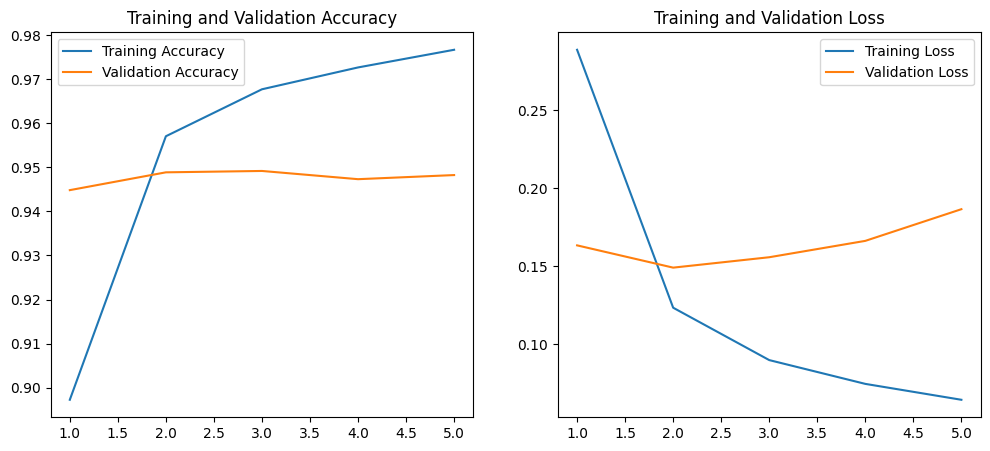

In [24]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history_gru)

## Model Evaluation

In [25]:
y_pred_prob_gru = model_gru.predict(X_test_pad_gru)
y_pred_gru = np.argmax(y_pred_prob_gru, axis=1) 
y_true_gru = np.argmax(y_test_cat_gru, axis=1)  

print(classification_report(y_true_gru, y_pred_gru, target_names=le.classes_))

503/503 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step
              precision    recall  f1-score   support

    negative       0.90      0.98      0.94      5285
      netral       0.97      0.92      0.95      5400
    positive       0.99      0.95      0.97      5400

    accuracy                           0.95     16085
   macro avg       0.95      0.95      0.95     16085
weighted avg       0.95      0.95      0.95     16085



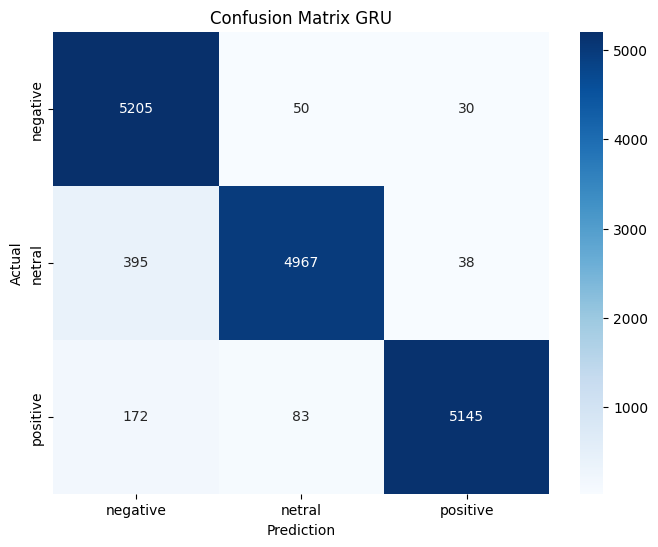

In [26]:
cm = confusion_matrix(y_true_gru, y_pred_gru)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix GRU')
plt.show()

# LSTM 70:30

## Data Splitting

In [27]:
df_lstm = df_final.copy()

X = df_lstm['text_final']
y = df_lstm['polarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=82, shuffle=True,  stratify=y)

## Tokenization, Padding and Embedding

In [28]:
tokenizer_lstm = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_lstm.fit_on_texts(X_train)

train_seq_lstm = tokenizer_lstm.texts_to_sequences(X_train)
test_seq_lstm = tokenizer_lstm.texts_to_sequences(X_test)

X_train_pad_lstm = pad_sequences(train_seq_lstm, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad_lstm = pad_sequences(test_seq_lstm, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(f"Shape X_train_pad: {X_train_pad_lstm.shape}") 

le = LabelEncoder()

y_train_enc_lstm = le.fit_transform(y_train)
y_test_enc_lstm = le.transform(y_test)

print("Mapping Label:", dict(zip(le.classes_, le.transform(le.classes_))))

y_train_cat_lstm = to_categorical(y_train_enc_lstm, num_classes=3)
y_test_cat_lstm = to_categorical(y_test_enc_lstm, num_classes=3)

print(f"Shape y_train_cat: {y_train_cat_lstm.shape}")

Shape X_train_pad: (56297, 100)
Mapping Label: {'negative': np.int64(0), 'netral': np.int64(1), 'positive': np.int64(2)}
Shape y_train_cat: (56297, 3)


# Modeling

In [29]:
batch_size = 64 
epochs = 15 

print("TRAINING LSTM MODEL")
print("==================")

checkpoint_lstm = ModelCheckpoint(filepath='best_model_lstm.keras', monitor='val_accuracy', save_best_only=True)

model_lstm = build_model(model_type='lstm')
history_lstm = model_lstm.fit(
    X_train_pad_lstm, y_train_cat_lstm,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint_lstm], 
    verbose=1
)

TRAINING LSTM MODEL


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,219 (2.57 MB)

 Trainable params: 673,219 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 203s 253ms/step - accuracy: 0.7747 - loss: 0.5257 - val_accuracy: 0.9394 - val_loss: 0.1720
Epoch 2/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 201s 254ms/step - accuracy: 0.9571 - loss: 0.1242 - val_accuracy: 0.9485 - val_loss: 0.1524
Epoch 3/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 200s 253ms/step - accuracy: 0.9703 - loss: 0.0837 - val_accuracy: 0.9467 - val_loss: 0.1569
Epoch 4/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 201s 254ms/step - accuracy: 0.9749 - loss: 0.0692 - val_accuracy: 0.9435 - val_loss: 0.1699
Epoch 5/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 202s 255ms/step - accuracy: 0.9799 - loss: 0.0581 - val_accuracy: 0.9446 - val_loss: 0.1781


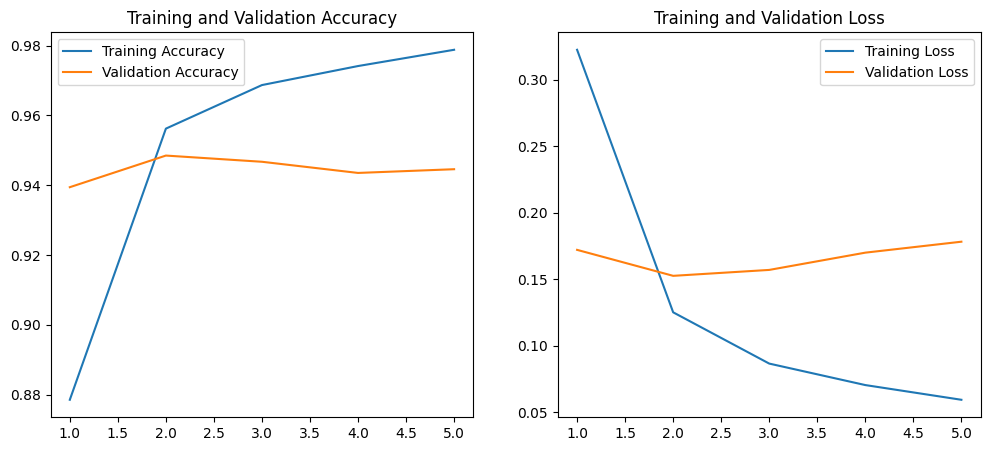

In [30]:
plot_history(history_lstm)

## Model Evaluation

In [31]:
y_pred_prob_lstm = model_lstm.predict(X_test_pad_lstm)
y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1) 
y_true_lstm = np.argmax(y_test_cat_lstm, axis=1)  

print(classification_report(y_true_lstm, y_pred_lstm, target_names=le.classes_))

754/754 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step
              precision    recall  f1-score   support

    negative       0.90      0.98      0.94      7928
      netral       0.97      0.92      0.94      8100
    positive       0.98      0.96      0.97      8100

    accuracy                           0.95     24128
   macro avg       0.95      0.95      0.95     24128
weighted avg       0.95      0.95      0.95     24128



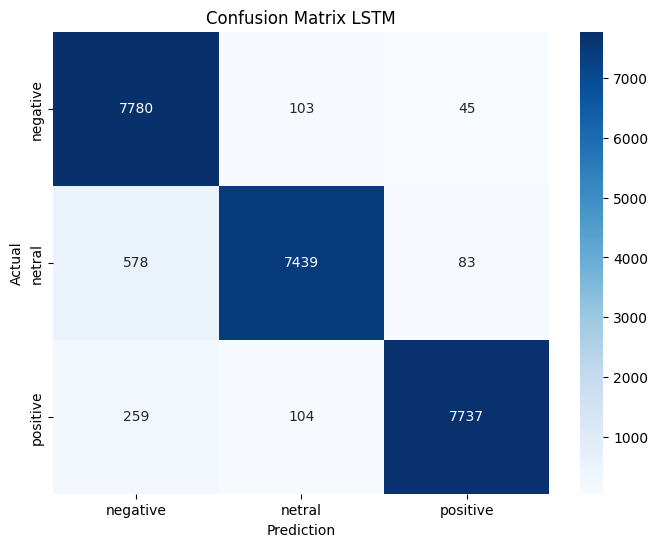

In [32]:
cm = confusion_matrix(y_true_lstm, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix LSTM')
plt.show()

# BERT 80:20

In [33]:
df_bert = df_final.copy()

X = df_bert['text_final']
y = df_bert['polarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82, shuffle=True,  stratify=y)

In [34]:
tokenizer_bert = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [35]:
def encode_data(data, max_length=100):
    input_ids = []
    attention_masks = []
    
    if not isinstance(data, list):
        texts = data.tolist()

    for text in data:
        encoded = tokenizer_bert.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',   
            truncation=True,       
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)

max_length = 100
train_ids, train_masks = encode_data(X_train, max_length)
test_ids, test_masks = encode_data(X_test, max_length)

print(f"Shape Train IDs: {train_ids.shape}")
print(f"Shape Train Masks: {train_masks.shape}")

Shape Train IDs: (64340, 100)
Shape Train Masks: (64340, 100)


In [36]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
print("Mapping Label:", dict(zip(le.classes_, le.transform(le.classes_))))

Mapping Label: {'negative': np.int64(0), 'netral': np.int64(1), 'positive': np.int64(2)}


In [37]:
# Build Model
model = TFBertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=3)

optimizer = tf_keras.optimizers.Adam(learning_rate=2e-5)
loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf_keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  124441344 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 124443651 (474.71 MB)
Trainable params: 124443651 (474.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
early_stopping = tf_keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001,
    patience=2, 
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = tf_keras.callbacks.ModelCheckpoint(
    filepath='best_indobert.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    x=[train_ids, train_masks], 
    y=y_train_enc,
    validation_data=([test_ids, test_masks], y_test_enc), 
    epochs=5,
    batch_size=32, 
    callbacks=[early_stopping, checkpoint_cb]
)

Epoch 1/5


I0000 00:00:1768731980.834958     124 service.cc:152] XLA service 0x7e8aa8126400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768731980.835043     124 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768731980.917568     124 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768731981.110610     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2011/2011 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.9218
Epoch 1: val_accuracy improved from -inf to 0.95188, saving model to best_indobert.h5
2011/2011 [==============================] - 882s 414ms/step - loss: 0.2208 - accuracy: 0.9218 - val_loss: 0.1378 - val_accuracy: 0.9519
Epoch 2/5
2011/2011 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9578
Epoch 2: val_accuracy improved from 0.95188 to 0.95667, saving model to best_indobert.h5
2011/2011 [==============================] - 829s 412ms/step - loss: 0.1203 - accuracy: 0.9578 - val_loss: 0.1224 - val_accuracy: 0.9567
Epoch 3/5
2011/2011 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9691
Epoch 3: val_accuracy improved from 0.95667 to 0.95766, saving model to best_indobert.h5
2011/2011 [==============================] - 829s 412ms/step - loss: 0.0841 - accuracy: 0.9691 - val_loss: 0.1191 - val_accuracy: 0.9577
Epoch 4/5
2011/2011 [=======================

In [41]:
# Evaluation Model
results = model.evaluate(x=[test_ids, test_masks], y=y_test_enc)
print(f"Loss: {results[0]}, Accuracy: {results[1]}")

y_pred_logits = model.predict(x=[test_ids, test_masks])
y_pred = np.argmax(y_pred_logits.logits, axis=1) 
y_true = y_test_enc

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=le.classes_))

503/503 [==============================] - 68s 135ms/step - loss: 0.1191 - accuracy: 0.9577
Loss: 0.11912109702825546, Accuracy: 0.9576624035835266
503/503 [==============================] - 67s 132ms/step

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    negative       0.95      0.95      0.95      5285
      netral       0.94      0.96      0.95      5400
    positive       0.98      0.96      0.97      5400

    accuracy                           0.96     16085
   macro avg       0.96      0.96      0.96     16085
weighted avg       0.96      0.96      0.96     16085



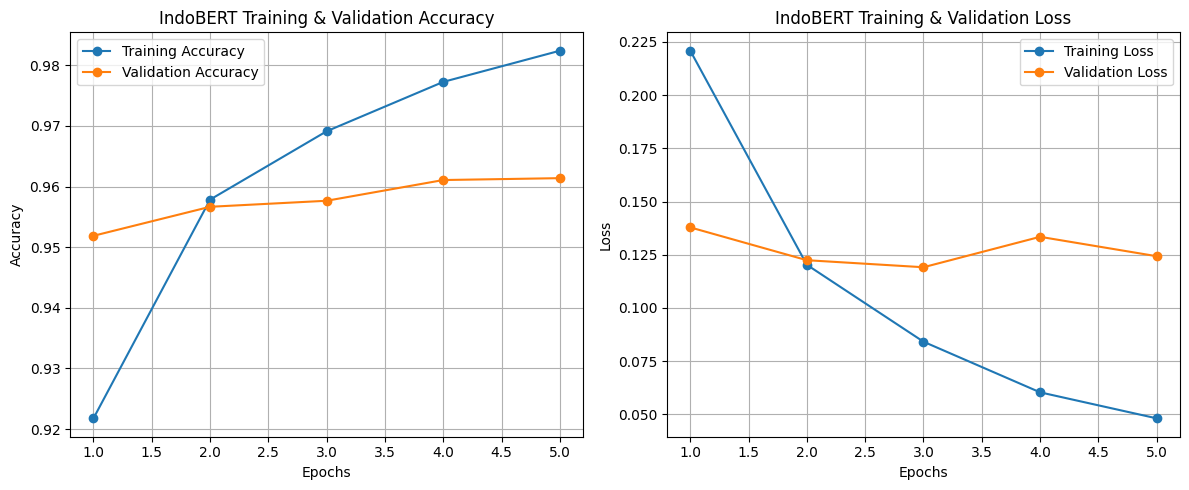

In [42]:
def plot_bert(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.title('IndoBERT Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.title('IndoBERT Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_bert(history)

In [43]:
save_dir = "./model_indobert_traveloka"

model.save_pretrained(save_dir)
tokenizer_bert.save_pretrained(save_dir)

shutil.make_archive("indobert_traveloka_full", 'zip', save_dir)

print(f"✅ Finishhhhh! Model in {save_dir}")

✅ Finishhhhh! Model in ./model_indobert_traveloka


# Inference 

In [47]:
def predict_sentiment(text):
    seq_gru = tokenizer_gru.texts_to_sequences([text]) 
    padded_gru = pad_sequences(seq_gru, maxlen=100)
    res_gru = model_gru.predict(padded_gru, verbose=0)

    seq_lstm = tokenizer_lstm.texts_to_sequences([text])
    padded_lstm = pad_sequences(seq_lstm, maxlen=100)
    res_lstm = model_lstm.predict(padded_lstm, verbose=0)


    inputs = tokenizer_bert(
        text, 
        add_special_tokens=True,
        max_length=100, 
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    
    prediction_bert = model.predict([inputs['input_ids'], inputs['attention_mask']], verbose=0)
    prob_bert = tf.nn.softmax(prediction_bert.logits, axis=-1).numpy()[0]

    labels = le.classes_ 
    
    def get_result(prob_array):
        idx = np.argmax(prob_array)
        return labels[idx], np.max(prob_array)

    label_gru, conf_gru = get_result(res_gru[0])
    label_lstm, conf_lstm = get_result(res_lstm[0])
    label_bert, conf_bert = get_result(prob_bert)

    print(f"💬 Teks: \"{text}\"")
    print(f"{'-'*60}")
    print(f" GRU      : {label_gru.upper():<10} | Confidence: {conf_gru*100:.2f}%")
    print(f" LSTM     : {label_lstm.upper():<10} | Confidence: {conf_lstm*100:.2f}%")
    print(f" IndoBERT : {label_bert.upper():<10} | Confidence: {conf_bert*100:.2f}%")
    print(f"{'='*60}\n")

In [55]:
reviews = [
    "Sangat puas sekali dengan layanannya, respon cepat dan packing sangat aman! Bintang lima pokoknya. Oke polll",
    "Aplikasi ini pintar sekali, memudahkan saya dalam mengatur jadwal harian, fungsionalitasnya luar biasa.",
    "Kualitas produk sesuai dengan harga yang ditawarkan.",
    "Fiturnya standar saja sih, tapi cukup oke untuk penggunaan sehari-hari.",
    "Sangat lambat responnya, sudah menunggu berjam-jam tapi tidak ada kepastian sama sekali.",
    "Benci banget sama update terbarunya, aplikasinya malah jadi sering lag dan sering keluar sendiri. gabanget deh pokonya",
    "Bagus sih, cuma appnya kadang lemot banget huhuuhu :(",
    "gud gudd gud",
    "ihh suka banget sama tampilan app barunya, cuma agak lemot sih ",
    "please, balikinnn fitur lama",
    "duh, lemot lagi deh :)",
    "pol cakep banget",
    "cukup lah",
    "cpt ok"
]

In [56]:
for text in reviews:
    predict_sentiment(text)

💬 Teks: "Sangat puas sekali dengan layanannya, respon cepat dan packing sangat aman! Bintang lima pokoknya. Oke polll"
------------------------------------------------------------
 GRU      : POSITIVE   | Confidence: 99.85%
 LSTM     : POSITIVE   | Confidence: 99.38%
 IndoBERT : POSITIVE   | Confidence: 99.87%

💬 Teks: "Aplikasi ini pintar sekali, memudahkan saya dalam mengatur jadwal harian, fungsionalitasnya luar biasa."
------------------------------------------------------------
 GRU      : NEGATIVE   | Confidence: 87.49%
 LSTM     : NEGATIVE   | Confidence: 91.26%
 IndoBERT : POSITIVE   | Confidence: 44.57%

💬 Teks: "Kualitas produk sesuai dengan harga yang ditawarkan."
------------------------------------------------------------
 GRU      : POSITIVE   | Confidence: 99.95%
 LSTM     : POSITIVE   | Confidence: 99.93%
 IndoBERT : POSITIVE   | Confidence: 99.91%

💬 Teks: "Fiturnya standar saja sih, tapi cukup oke untuk penggunaan sehari-hari."
----------------------------------------